In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn

import torch
cuda = torch.cuda.is_available()
print("GPU:", cuda)

GPU: True


In [2]:
#load our train dataset.

train = pd.read_csv("~/datasets/mnist/train.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Splitting train dataset into X and Y.Normalizing it by dividing it with 255

X = train.iloc[:,1:].values / 255
Y = train.iloc[:,0].values

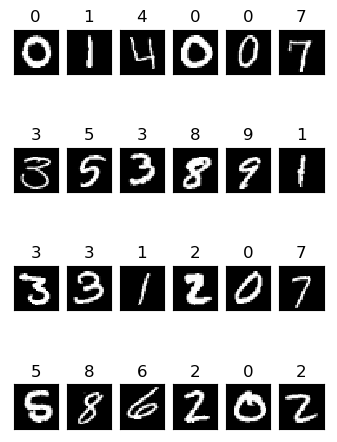

In [5]:
#visulaizing numbers in our dataset.
r = 4
c = 6
fig=plt.figure(figsize=(r, c),dpi=100)
for i in range(1, r*c+1):
    img = X[i].reshape(28,28)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(Y[i])
    
    plt.imshow(img,cmap='gray')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.2)

In [7]:
#converting our data into a datloader object.

trn_x = torch.from_numpy(trn_x).type(torch.FloatTensor).view(-1,1,28,28)
trn_y = torch.from_numpy(trn_y).type(torch.LongTensor)

val_x = torch.from_numpy(val_x).type(torch.FloatTensor).view(-1,1,28,28)
val_y = torch.from_numpy(val_y).type(torch.LongTensor)

In [8]:
from torch.utils.data import TensorDataset,DataLoader

trn = TensorDataset(trn_x,trn_y)
trn = DataLoader(trn,batch_size=1000)

In [9]:
shape = trn_x[0].shape
shape

torch.Size([1, 28, 28])

In [10]:
import torch.nn as nn
import torch.nn.functional as F



# Formula to calculate shape as we go through layer by layer = [(X - F + 2P)/S] + 1
# Here,
# X = Width / Height
# F = Kernel size
# P = Padding
# S = Strides (default = 1)

#Our input to the first layer is going to be [batchsize,1,28,28]
#substitute, =[(28 - 5 + 2(0))/1] + 1
#             =[(23)/1] + 1
#             =23 + 1
#             =24


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1,16,5) #(channels,output,kernel_size)   [Batch_size,1,28,28]  --> [Batch_size,16,24,24]
        self.mxp1 = nn.MaxPool2d(2)   #                                 [Batch_size,16,24,24] --> [Batch_size,16,24/2,24/2] --> [Batch_size,16,12,12]
        self.conv2 = nn.Conv2d(16,24,5) #                               [Batch_size,16,12,12] --> [Batch_size,24,8,8]
        self.mxp2 = nn.MaxPool2d(2)   #                                 [Batch_size,24,8,8] ---> [Batch_size,32,8/2,8/2] ---> [Batch_size,24,4,4]
        self.linear1 = nn.Linear(24 * 4 * 4, 100)                       #input shape --> 100 outputs
        self.linear2 = nn.Linear(100,10)                                #100 inputs --> 10 outputs
        
    def forward(self,x):
        X = self.mxp1(F.relu(self.conv1(x)))
        X = self.mxp2(F.relu(self.conv2(X)))
        X = X.view(-1, 24 * 4 * 4)  #reshaping to input shape
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return F.log_softmax(X, dim=1)

cnn = Model()

if cuda:
    cnn.cuda()
    
print(cnn)

Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (mxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1))
  (mxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=384, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)


In [11]:
#define our optimizer
from torch.optim import Adam

optimizer = Adam(cnn.parameters(), lr=1e-3)

In [12]:
def compute_val_loss(val_x,val_y,model):
    model.eval()
    if cuda:
        val_x,val_y = val_x.cuda(),val_y.cuda()
    output = model(val_x)
    loss = F.cross_entropy(output,val_y)
    return loss

In [13]:
EPOCHS = 10

trn_loss = []
val_loss = []

cnn.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(trn):

        if cuda:
            data,target = data.cuda(),target.cuda()
            
        optimizer.zero_grad()

        y_pred = cnn(data)

        loss = F.cross_entropy(y_pred, target)
        trn_loss.append(loss.cpu().data.item())
        
        loss.backward()
        optimizer.step()
        
        loss = compute_val_loss(val_x,val_y,cnn)
        val_loss.append(loss.cpu().data.item())

    print("Epoch: {} | loss: {} | val_loss: {}".format(epoch+1,trn_loss[-1],val_loss[-1]))

Epoch: 1 | loss: 0.5311260223388672 | val_loss: 0.5512191653251648
Epoch: 2 | loss: 0.3040064871311188 | val_loss: 0.3407435417175293
Epoch: 3 | loss: 0.207854226231575 | val_loss: 0.2602977454662323
Epoch: 4 | loss: 0.16631390154361725 | val_loss: 0.2124299257993698
Epoch: 5 | loss: 0.1342320293188095 | val_loss: 0.17860989272594452
Epoch: 6 | loss: 0.1134849563241005 | val_loss: 0.14758068323135376
Epoch: 7 | loss: 0.10182631760835648 | val_loss: 0.12470005452632904
Epoch: 8 | loss: 0.09027834236621857 | val_loss: 0.11366236209869385
Epoch: 9 | loss: 0.08266660571098328 | val_loss: 0.10554780066013336
Epoch: 10 | loss: 0.07446286082267761 | val_loss: 0.10033958405256271


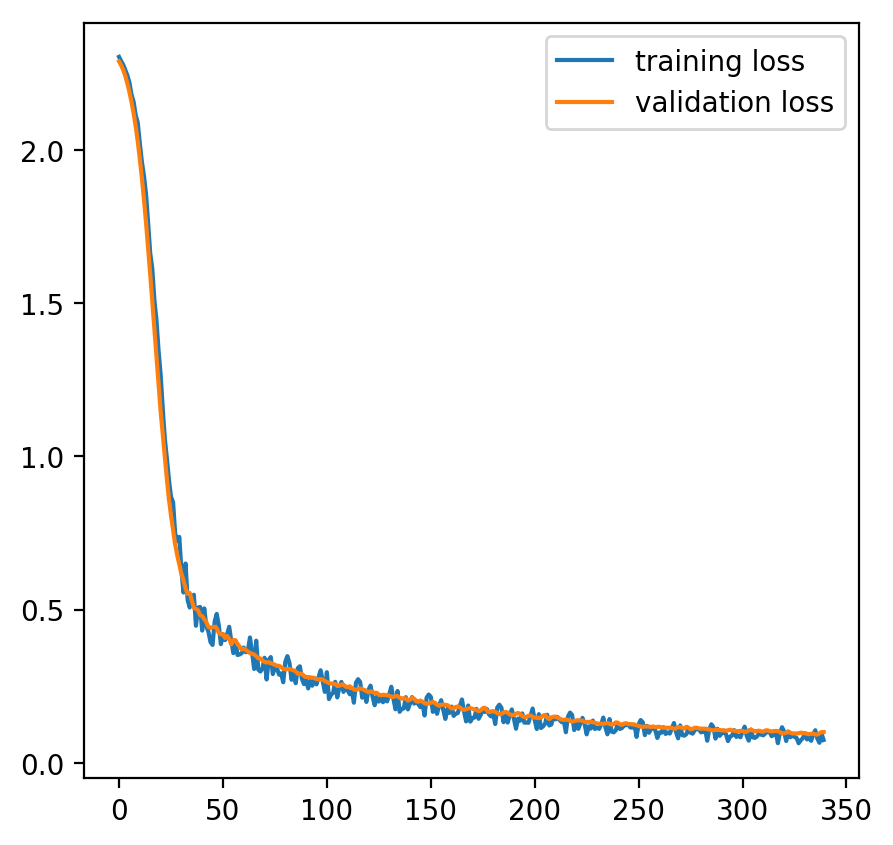

In [14]:
plt.figure(figsize=(5,5),dpi=200)
plt.plot(trn_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='upper right')

In [15]:
def predict_with_pytorch(model,val_x):
    model.eval()
    y_preds = []
    
    if cuda:
        val_x = val_x.cuda()
   
    out = model(val_x)
    _, predicted = torch.max(out.data,1)
    
    for p in predicted:
        y_preds.append(p.detach().cpu().numpy().item())
        
        
    return y_preds    

In [16]:
#predicting validation set and plotting a heatmap.

pred = predict_with_pytorch(cnn,val_x)

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_y.numpy(),pred)

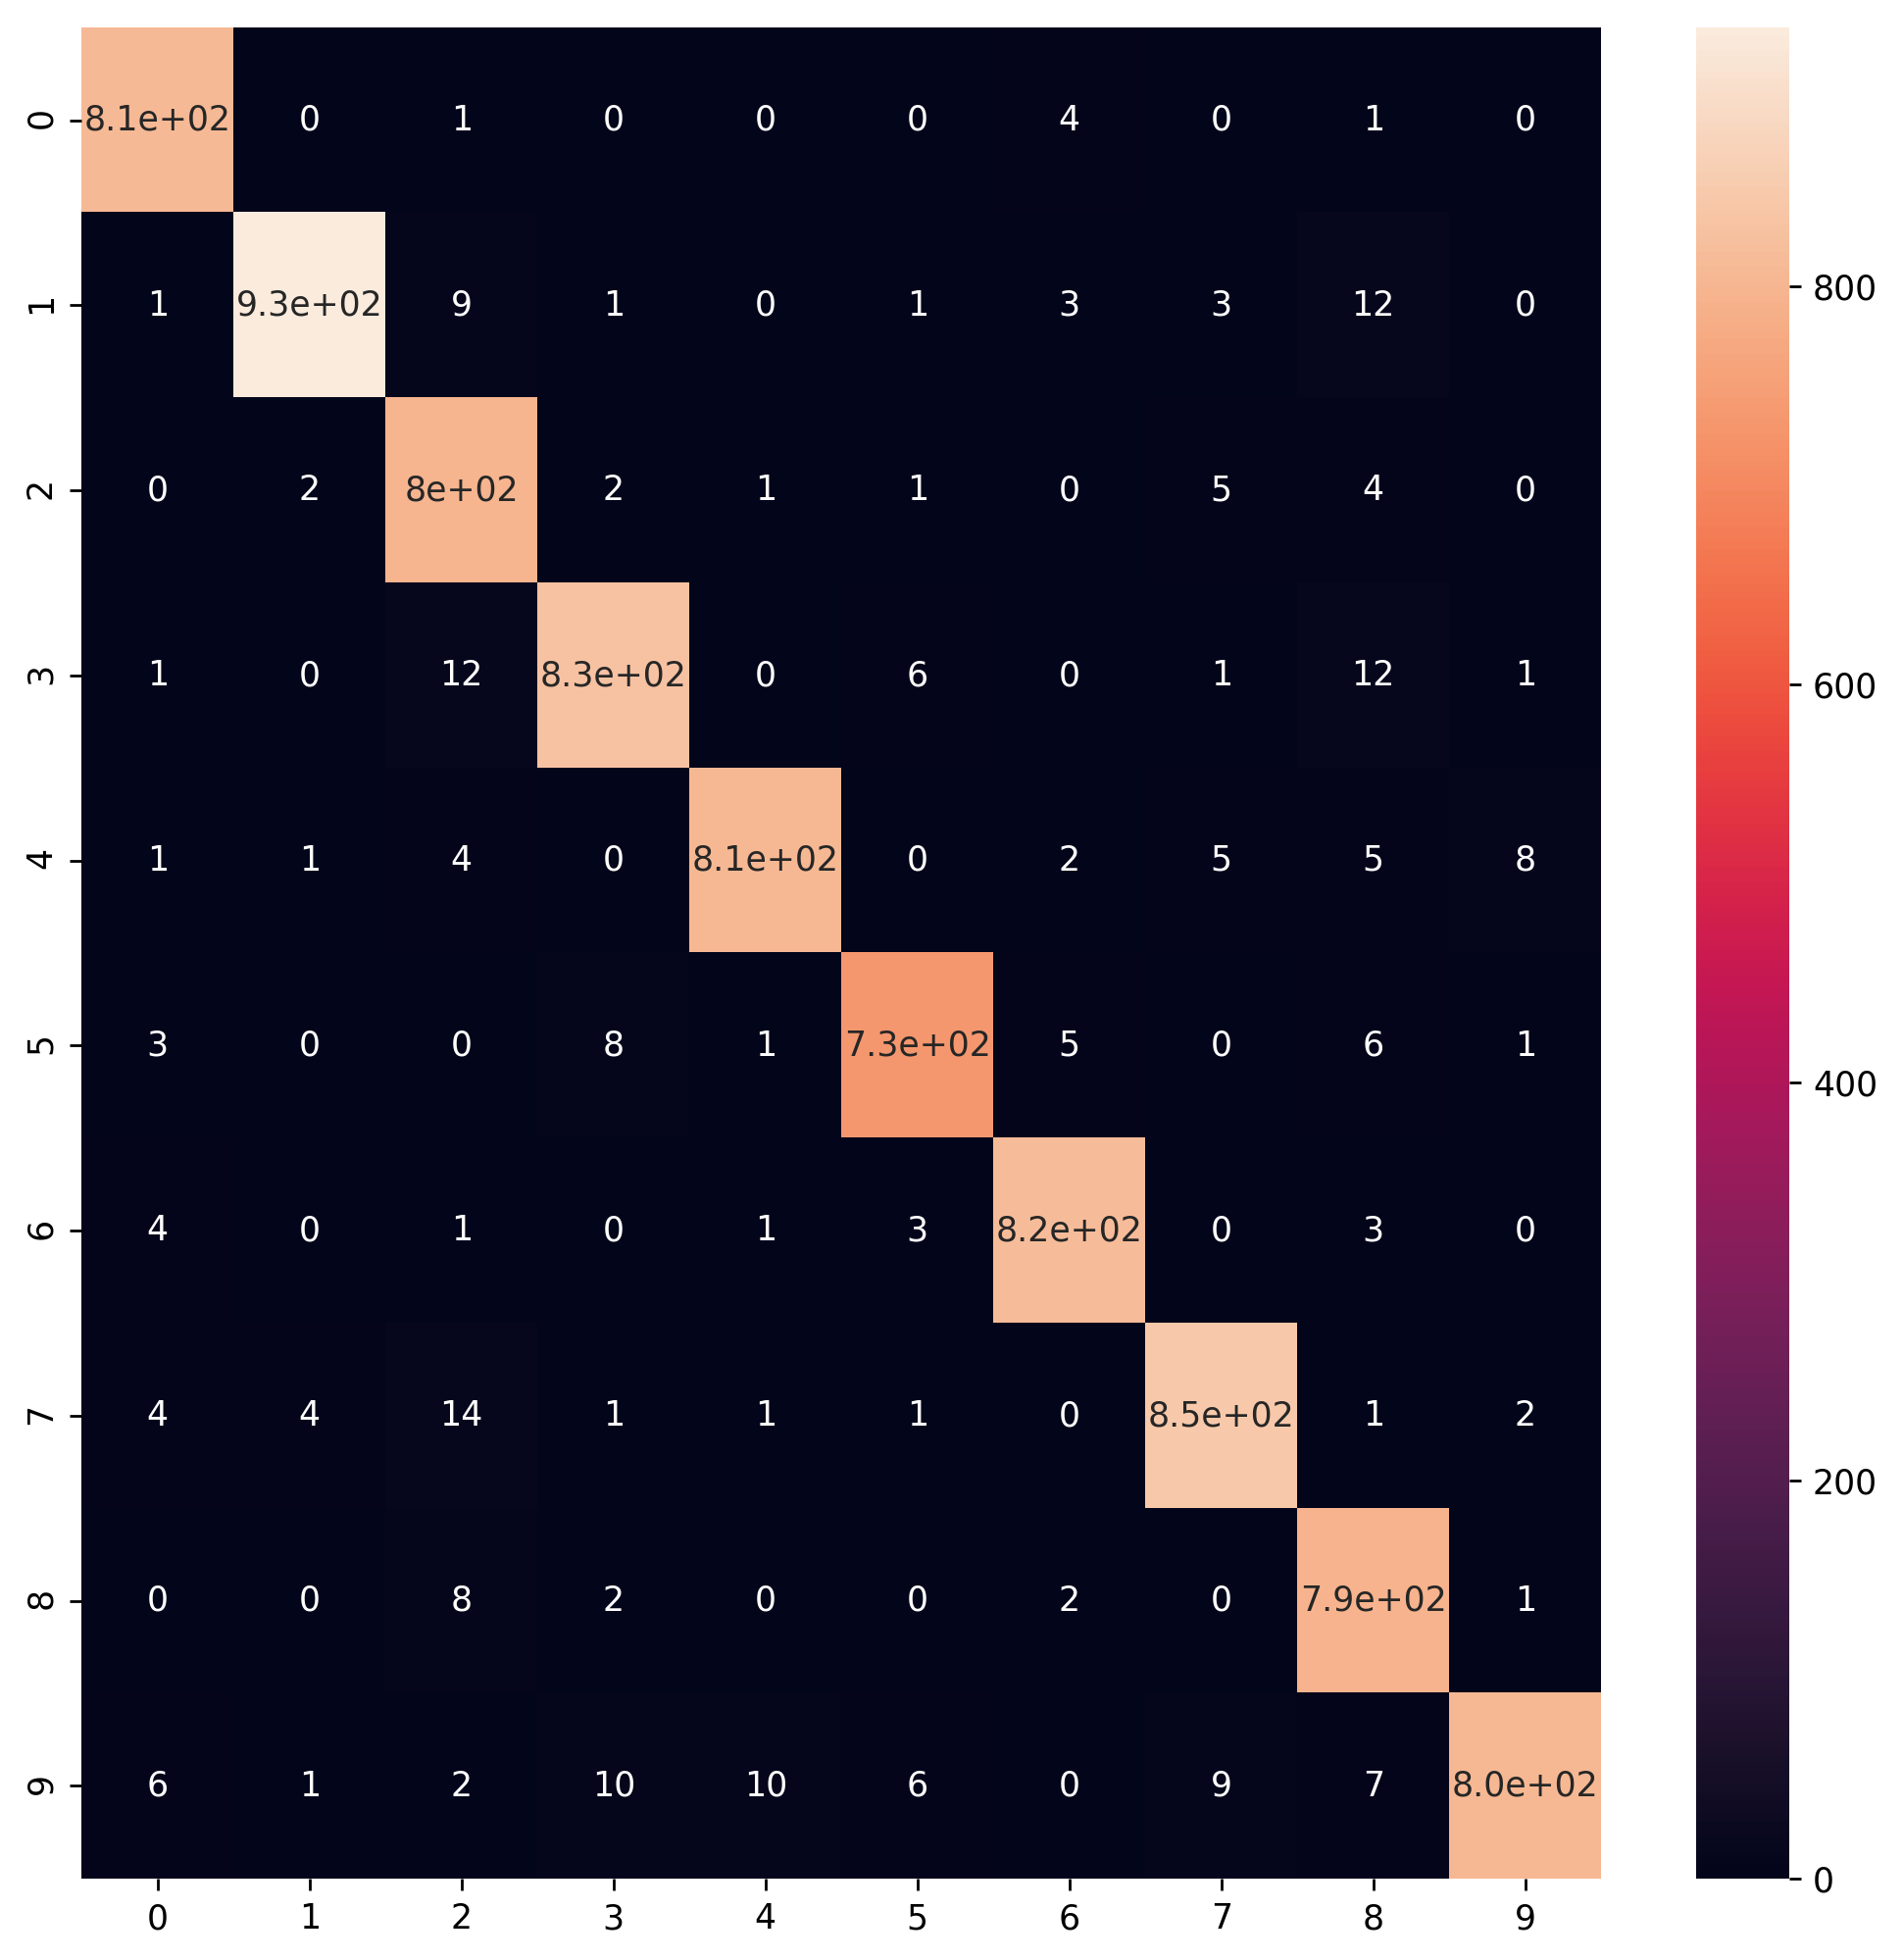

In [18]:
plt.figure(figsize = (10,10),dpi=250)
seaborn.heatmap(cm,annot=True)

In [19]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(val_y.numpy(),pred)

print("Accuracy:",acc*100,"%")

Accuracy: 97.1666666667 %
